<a href="https://colab.research.google.com/github/AlfredoMarino/cifar10/blob/main/cnn_cifar10_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [43]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.callbacks import LearningRateScheduler
from keras.models import load_model

from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
import random

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [44]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [45]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

In [46]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [47]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [48]:
y_train = y_train.ravel()
y_test = y_test.ravel()

print("y_train", y_train)
print("y_test", y_test)

y_train [6 9 9 ... 9 1 1]
y_test [3 8 8 ... 5 1 7]


In [49]:
y_train_label = y_train

Obtenemos un array con todas las labels de CIFAR10

In [50]:
cifar10_labels = [
  'airplane', # id 0
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


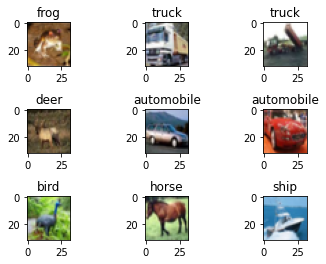

In [51]:
# Pintemos una muestra de las las imagenes del dataset CIFAR10

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [52]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [53]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


### Vemos ejemplos del data augumentation

In [54]:
train_batch_size = 32
val_batch_size = 20

In [55]:
# Data augmentation

train_datagen = ImageDataGenerator(
    rescale=(1./255),
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=train_batch_size
)

validation_datagen = ImageDataGenerator(
    rescale=(1./255)
)

validation_generator = validation_datagen.flow(
    x_val,
    y_val,
    batch_size=val_batch_size
)

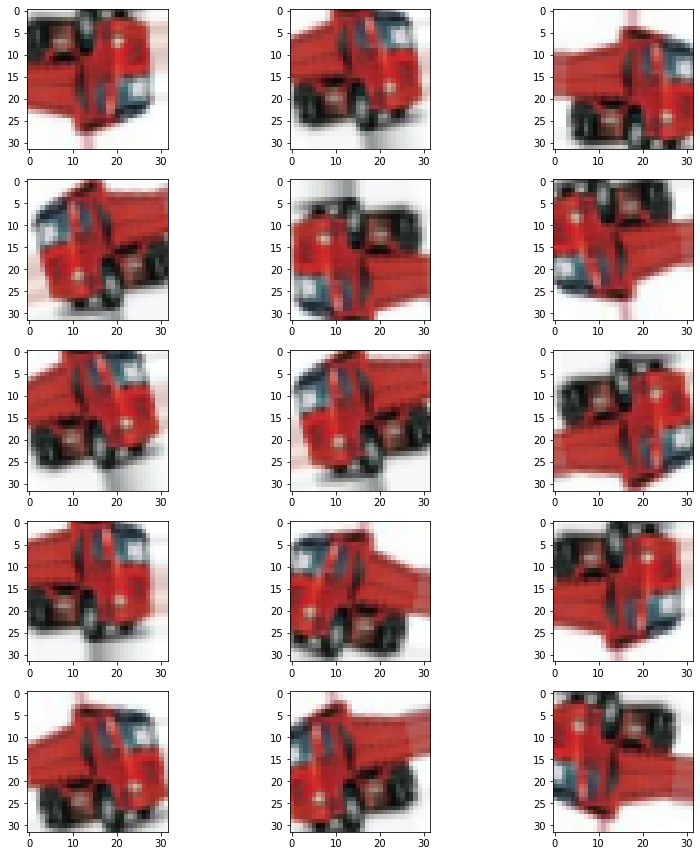

In [56]:
sample = random.choice(range(0,1457))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=20
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 3. Arquitectura de red del modelo - Proyecto 0


In [82]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,3),
                 kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', 
                 kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                  kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_32 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_33 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

## 4. Optimizador, función error


In [84]:
#opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)


def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

opt_rms = RMSprop()
opt_sgd = SGD()

In [85]:
model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [86]:
# callback EarlyStopping basado en Accuracy
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=25)

# callback EarlyStopping basadon en Loss
callback_loss = EarlyStopping(monitor='val_loss', patience=25)

# callback ModelCheckpoint basado en Accuracy
callback_checkpoint = ModelCheckpoint('best_cifa10.hdf5', verbose=1, save_best_only=True, monitor = 'val_accuracy')

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [87]:
t = time.perf_counter()

In [88]:
print(f"x_train.shape[0]: {x_train.shape[0]}")
print(f"x_val.shape[0]: {x_val.shape[0]}")

x_train.shape[0]: 40000
x_val.shape[0]: 10000


In [89]:
print(f"step_per_epoch: {x_train.shape[0] // train_batch_size}")
print(f"validation_steps: {x_val.shape[0] // val_batch_size}")

step_per_epoch: 1250
validation_steps: 500


In [ ]:
history = model.fit(
    train_generator,
    epochs=120,
    validation_data=validation_generator,
    steps_per_epoch=x_train.shape[0] // train_batch_size,
    validation_steps=x_val.shape[0] // val_batch_size,
    callbacks=[LearningRateScheduler(lr_schedule), callback_checkpoint, callback_accuracy]
)

Epoch 1/120
1249/1250 [============================>.] - ETA: 0s - loss: 2.3141 - accuracy: 0.2881
Epoch 1: val_accuracy improved from -inf to 0.22030, saving model to best_cifa10.hdf5
1250/1250 [==============================] - 53s 41ms/step - loss: 2.3134 - accuracy: 0.2882 - val_loss: 3.6695 - val_accuracy: 0.2203 - lr: 0.0010
Epoch 2/120
1249/1250 [============================>.] - ETA: 0s - loss: 1.7717 - accuracy: 0.4091
Epoch 2: val_accuracy improved from 0.22030 to 0.43440, saving model to best_cifa10.hdf5
1250/1250 [==============================] - 51s 41ms/step - loss: 1.7716 - accuracy: 0.4091 - val_loss: 1.6038 - val_accuracy: 0.4344 - lr: 0.0010
Epoch 3/120
1250/1250 [==============================] - ETA: 0s - loss: 1.5587 - accuracy: 0.4717
Epoch 3: val_accuracy improved from 0.43440 to 0.51800, saving model to best_cifa10.hdf5
1250/1250 [==============================] - 52s 42ms/step - loss: 1.5587 - accuracy: 0.4717 - val_loss: 1.4324 - val_accuracy: 0.5180 - lr: 0.

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [ ]:
saved_model = load_model("best_cifa10.hdf5")
_, acc = saved_model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

In [ ]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = saved_model.predict(x_test)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
ruta_googledrive = "/content/drive/MyDrive/Colab Notebooks/h5_backups/" # A revisar en vuestra instancia

model.save(ruta_googledrive+'cifar10_base_model.h5')